#### Usando o Pandas
Para carregar e explorar o dataset de churn de telecomunicações do Kaggle no python como um DataFrame.

In [10]:
import pandas as pd

# Carregando o DataFrame baixado em "rawKaggle"
df = pd.read_csv('../data/raw/telecom_churn.csv')

# Explorando o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

#### Usando o Pycaret I.
Para realizar o pré-processamento inicial dos dados de churn usando a biblioteca PyCaret.

In [11]:

from pycaret.classification import *

# Numero de Telefone: deve ser ignorado, não representa uma caracteristica determinante e pode causar overfitting e ruído.
# Código de Área: também se torna irrelevante, pois por mais que revele localização geografica de um cliente, temos a coluna "state" (estado) que é mais relevante.

recursos_categoricos = ['state', 'international plan', 'voice mail plan']

features_ignoradas = ['phone number', 'area code']

clf1 = setup(data=df,
             target='churn',
             session_id=123,

             # CORREÇÃO DO ERRO DE CONVERSÃO DE TIPO
             categorical_features=recursos_categoricos,

             # IGNORAR INFORMAÇÕES IRRELEVANTES
             ignore_features=features_ignoradas,

             # PRÉ-PROCESSAMENTO CRÍTICO PARA CHURN
             fix_imbalance=True,
             imputation_type='simple',
             normalize=False
            )

,Description,Value
0,Session id,123
1,Target,churn
2,Target type,Binary
3,Original data shape,"(3333, 21)"
4,Transformed data shape,"(4990, 19)"
5,Transformed train set shape,"(3990, 19)"
6,Transformed test set shape,"(1000, 19)"
7,Ignore features,2
8,Numeric features,15
9,Categorical features,3


Linha,Descrição,Valor,Significado
0. **Session id**,_123_,Garante a reprodutibilidade do seu experimento.
1. **Target**,_churn_,A coluna que você está tentando prever.
2. **Target type**,_Binary_,Confirma que é uma tarefa de Classificação Binária (Churn Sim/Não).
3. **Original data shape**,_"(3333, 21)"_,Seus dados originais tinham 3333 linhas e 21 colunas.
4. **Transformed data shape**,_"(4990, 19)"_,O PyCaret aumentou o número de linhas e diminuiu as colunas. O aumento de linhas é devido ao Fix imbalance.
5. **Transformed train set shape**,_"(3990, 19)"_,"O conjunto de treino (70% dos dados, 3333 * 0.7 = 2333, mas aumentado pelo SMOTE)."
6. **Transformed test set shape**,_"(1000, 19)"_,"O conjunto de teste (30% dos dados, que não é tocado)."
7. **Ignore features**,_2_,As duas colunas listadas (phone number e area code) foram descartadas.

 #### Usando o Pycaret II.
"Decidindo e montando o melhor modelo de classificação para prever churn."

In [3]:
ignore_list = ['lightgbm']
best_model = compare_models(sort = 'Recall', turbo = True, exclude= ignore_list)
# turbo é usado para acelerar o processo, mas pode sacrificar a precisão. Por isso não devo usar em produção.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.3521,0.7326,0.8414,0.1836,0.2713,0.0543,0.1134,0.0230
gbc,Gradient Boosting Classifier,0.9331,0.9011,0.7422,0.7929,0.7626,0.7239,0.7270,0.2290
rf,Random Forest Classifier,0.9370,0.8961,0.7305,0.8243,0.7698,0.7337,0.7384,0.1080
nb,Naive Bayes,0.7411,0.8005,0.7303,0.3258,0.4495,0.3118,0.3563,0.0160
qda,Quadratic Discriminant Analysis,0.7797,0.8019,0.7217,0.3681,0.4862,0.3646,0.3994,0.0190
lr,Logistic Regression,0.7698,0.8110,0.7185,0.3557,0.4750,0.3489,0.3850,0.3640
dt,Decision Tree Classifier,0.9023,0.8235,0.7126,0.6522,0.6791,0.6218,0.6239,0.0200
ridge,Ridge Classifier,0.7673,0.8030,0.7067,0.3514,0.4681,0.3407,0.3757,0.0170
lda,Linear Discriminant Analysis,0.7617,0.7987,0.7037,0.3438,0.4607,0.3307,0.3667,0.0160
et,Extra Trees Classifier,0.9284,0.8941,0.6414,0.8305,0.7175,0.6777,0.6887,0.0580


Vamos escolher o Gradient Boosting Classifier (GBC):

* **Recall** (0.7422): Ainda consegue identificar 74% dos clientes que vão cancelar.
* **Precisão** (0.7929): 80% dos clientes que o modelo marca para você ligar realmente vão cancelar. O custo de Falsos Positivos é muito baixo.
* **Acurácia** (0.9331) / AUC (0.9011): Excelente performance geral.

In [4]:
modeloGbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9359,0.8325,0.6176,0.9130,0.7368,0.7019,0.7193
1,0.9231,0.8681,0.7353,0.7353,0.7353,0.6903,0.6903
2,0.9103,0.8882,0.7647,0.6667,0.7123,0.6595,0.6616
3,0.9313,0.9250,0.6667,0.8148,0.7333,0.6944,0.6990
4,0.9185,0.8150,0.6970,0.7188,0.7077,0.6603,0.6604
5,0.9528,0.9407,0.7941,0.8710,0.8308,0.8034,0.8046
6,0.9399,0.9101,0.7647,0.8125,0.7879,0.7529,0.7534
7,0.9356,0.9456,0.7941,0.7714,0.7826,0.7448,0.7449
8,0.9442,0.9319,0.7353,0.8621,0.7937,0.7616,0.7648


In [5]:
# Vamos ajustar o modelo para melhorar ainda mais o Recall
modeloGbcAjustado = tune_model(modeloGbc, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8761,0.8306,0.6471,0.5641,0.6027,0.5297,0.5315
1,0.8632,0.8331,0.8235,0.5185,0.6364,0.5574,0.5801
2,0.8547,0.8857,0.7941,0.5000,0.6136,0.5298,0.5513
3,0.9185,0.9241,0.8182,0.6750,0.7397,0.6919,0.6964
4,0.8755,0.7800,0.6970,0.5476,0.6133,0.5404,0.5460
5,0.9356,0.9270,0.8235,0.7568,0.7887,0.7508,0.7518
6,0.9013,0.9146,0.8235,0.6222,0.7089,0.6508,0.6601
7,0.9056,0.9223,0.7941,0.6429,0.7105,0.6549,0.6601
8,0.9227,0.9257,0.7647,0.7222,0.7429,0.6974,0.6978


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [6]:
# Criando o Modelo final
modeloGbcFinal = finalize_model(modeloGbcAjustado)

##### Lógica de Negócio:
_(Não necessário)_

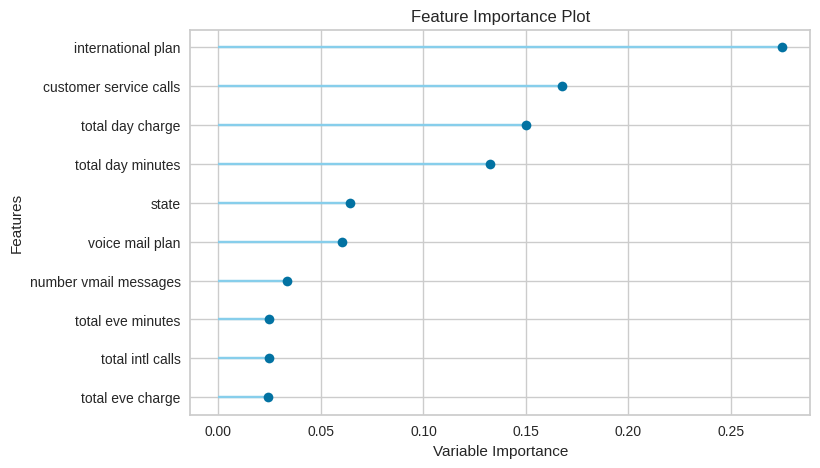

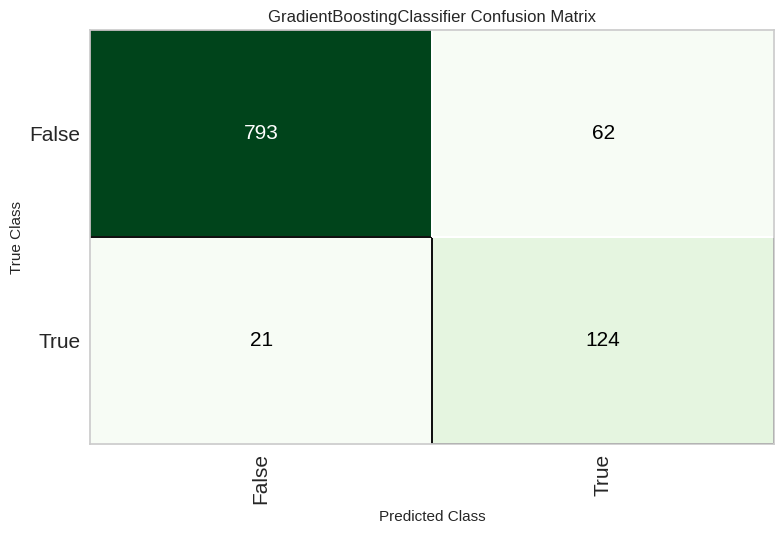

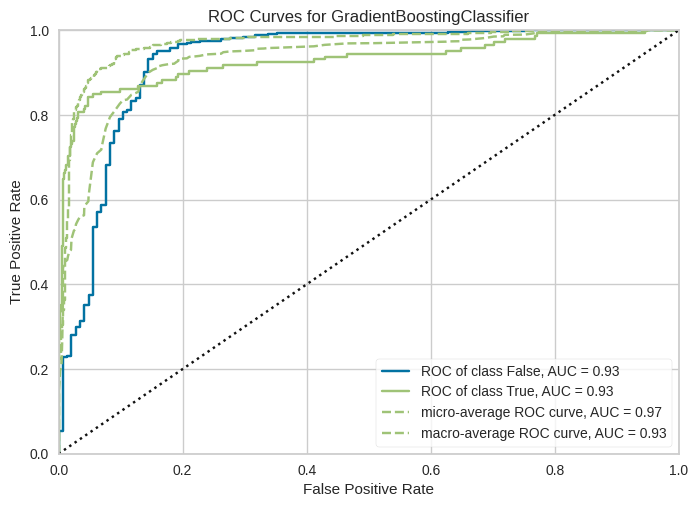

In [7]:
# 1. Importância das Features (Qual fator mais leva ao Churn?)
# O resultado deve ser salvo na pasta 'reports' da sua arquitetura.
plot_model(modeloGbcFinal, plot = 'feature')

# 2. Matriz de Confusão (Visualiza o Recall e a Precisão)
plot_model(modeloGbcFinal, plot = 'confusion_matrix')

# 3. Curva ROC/AUC (Avalia a capacidade de distinção do modelo)
plot_model(modeloGbcFinal, plot = 'auc')

In [8]:
# Salvando o modelo treinado para uso futuro
save_model(modeloGbcFinal, 'gbc')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['account length',
                                              'number vmail messages',
                                              'total day minutes',
                                              'total day calls',
                                              'total day charge',
                                              'total eve minutes',
                                              'total eve calls',
                                              'total eve charge',
                                              'total night minutes',
                                              'total night calls',
                                              'total night charge',
                                              'total intl minutes',
                                              'total intl calls',
 